In [43]:
# Importing Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold


In [44]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']

In [45]:
df = pd.read_csv(r"C:\Users\Aditya\OneDrive - Students RWTH Aachen University\Desktop\Techlabs\WISDMData.txt\WISDMData.txt", header=None, names=columns)


print(df.shape)


(1098209, 6)


DATA PRE-PROCESSING

In [46]:
# Remove null values from the DataFrame
df = df.dropna()
print("After removing null values:", df.shape)






After removing null values: (1098208, 6)


In [47]:
# Assuming you have a DataFrame har_df with a 'z-axis' column containing string values

df['z-axis'] = df['z-axis'].str.replace(';', '')



In [48]:
df = df[df['timestamp'] != 0]
print(df.shape)

(1085363, 6)


In [51]:
#Label Encoding (Activity as 1-6)
if df['activity'].isnull().sum() > 0:
    print("Warning: 'activity' column contains null values. Handle them before encoding.")
else:
    label_encode = LabelEncoder()
    df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())


In [52]:
#Normalizing

columns_to_normalize = ['x-axis', 'y-axis', 'z-axis']
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
print(df)



         user activity        timestamp    x-axis    y-axis    z-axis   
0          33  Jogging   49105962326000  0.478144  0.814390  0.515198  \
1          33  Jogging   49106062271000  0.622404  0.778664  0.526603   
2          33  Jogging   49106112167000  0.619649  0.769046  0.500337   
3          33  Jogging   49106222305000  0.480209  0.961070  0.579135   
4          33  Jogging   49106332290000  0.465749  0.799962  0.685236   
...       ...      ...              ...       ...       ...       ...   
1098204    19  Sitting  131623331483000  0.723205  0.454981  0.545293   
1098205    19  Sitting  131623371431000  0.724216  0.457755  0.546308   
1098206    19  Sitting  131623411592000  0.725228  0.459773  0.545293   
1098207    19  Sitting  131623491487000  0.723205  0.457755  0.546308   
1098208    19  Sitting  131623531465000  0.720172  0.461034  0.543263   

         activityEncode  
0                     1  
1                     1  
2                     1  
3                  

In [53]:
har_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [54]:
#  ascending order based on user and timestamp
har_df = har_df.sort_values(by = ['user', 'timestamp'], ignore_index=True)
test_df = test_df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [57]:
#size after pre-process
print(har_df.shape)
print(test_df.shape)

(868290, 7)
(217073, 7)


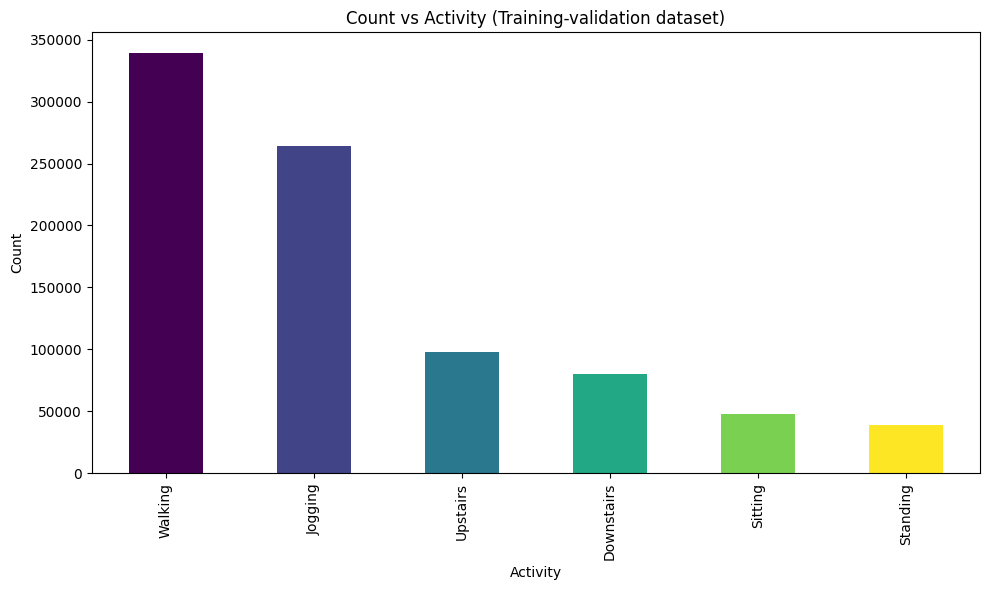

In [58]:
#Data count based on activity
activity_counts = har_df['activity'].value_counts()
n_colors = len(activity_counts)
colors = plt.cm.viridis(np.linspace(0, 1, n_colors))
plt.figure(figsize=(10, 6))  
activity_counts.plot(kind='bar', color=colors)
plt.title('Count vs Activity (Training-validation dataset)')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
from sklearn.preprocessing import MinMaxScaler

plt.show()

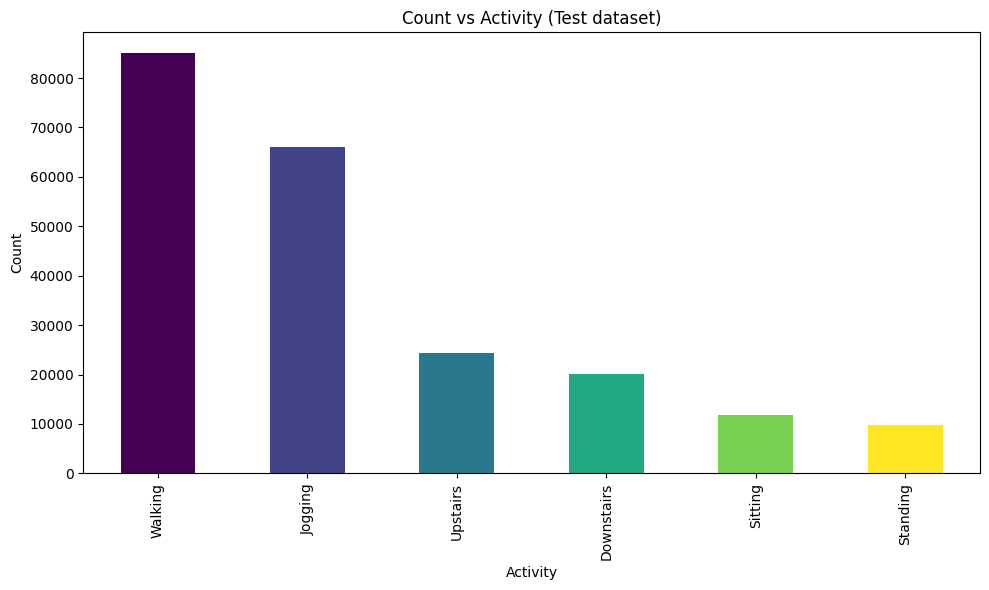

In [59]:
#Data count based on activity
activity_counts = test_df['activity'].value_counts()
n_colors = len(activity_counts)
colors = plt.cm.viridis(np.linspace(0, 1, n_colors))
plt.figure(figsize=(10, 6))  
activity_counts.plot(kind='bar', color=colors)
plt.title('Count vs Activity (Test dataset)')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
from sklearn.preprocessing import MinMaxScaler

plt.show()

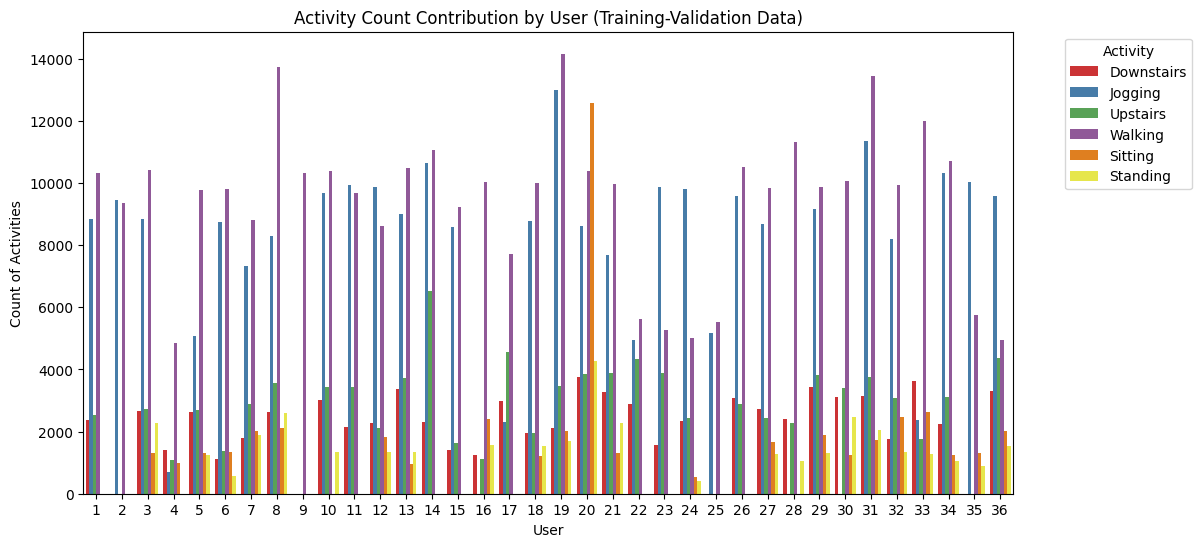

In [60]:
# Group the data by 'user' and 'activity' and count the occurrences
grouped_data = har_df.groupby(['user', 'activity']).size().reset_index(name='count')

palette = sns.color_palette('Set1', n_colors=len(har_df['activity'].unique()))

plt.figure(figsize=(12, 6)) 
sns.barplot(data=grouped_data, x='user', y='count', hue='activity', palette=palette)
plt.title('Activity Count Contribution by User (Training-Validation Data)')
plt.xlabel('User')
plt.ylabel('Count of Activities')
plt.legend(title='Activity', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

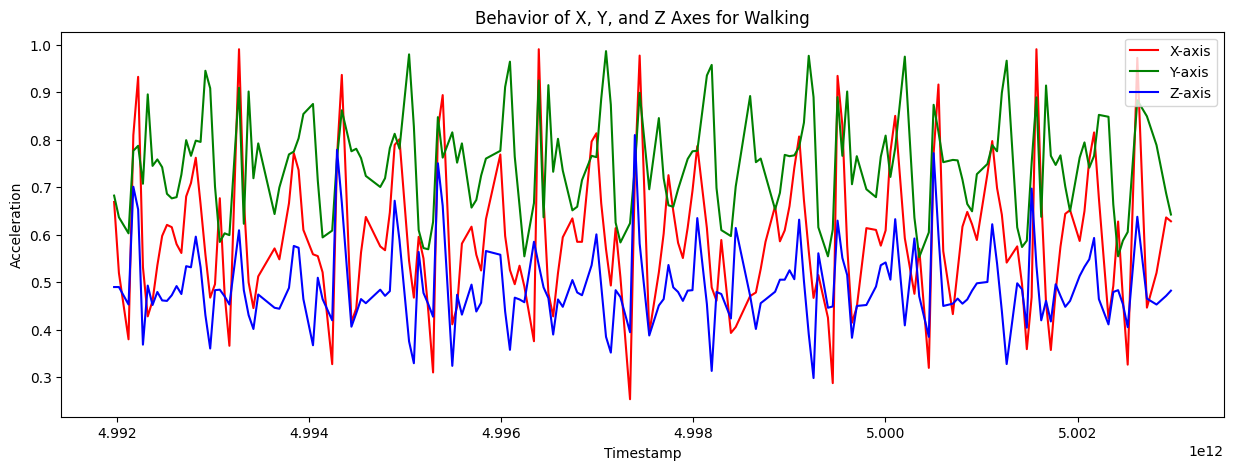

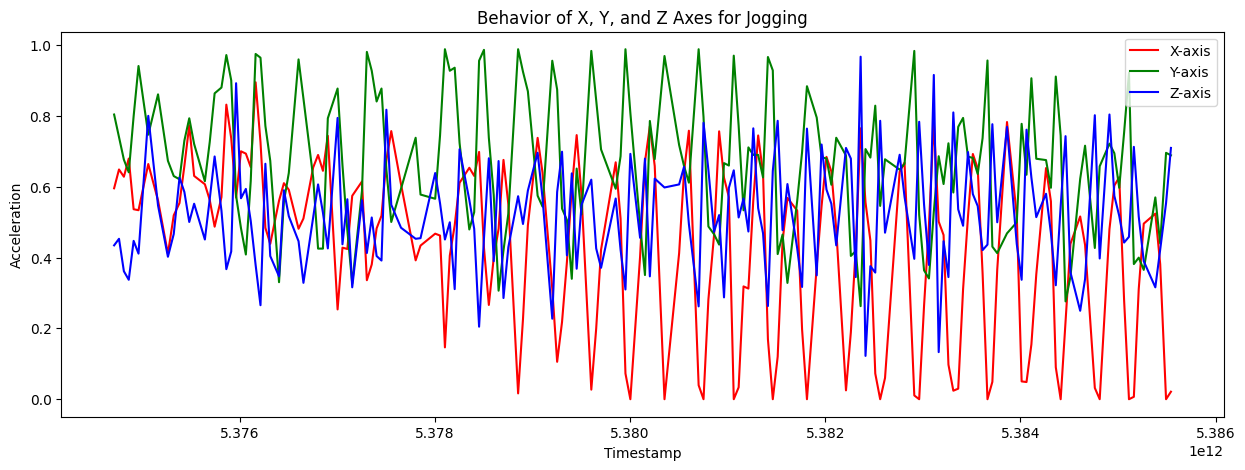

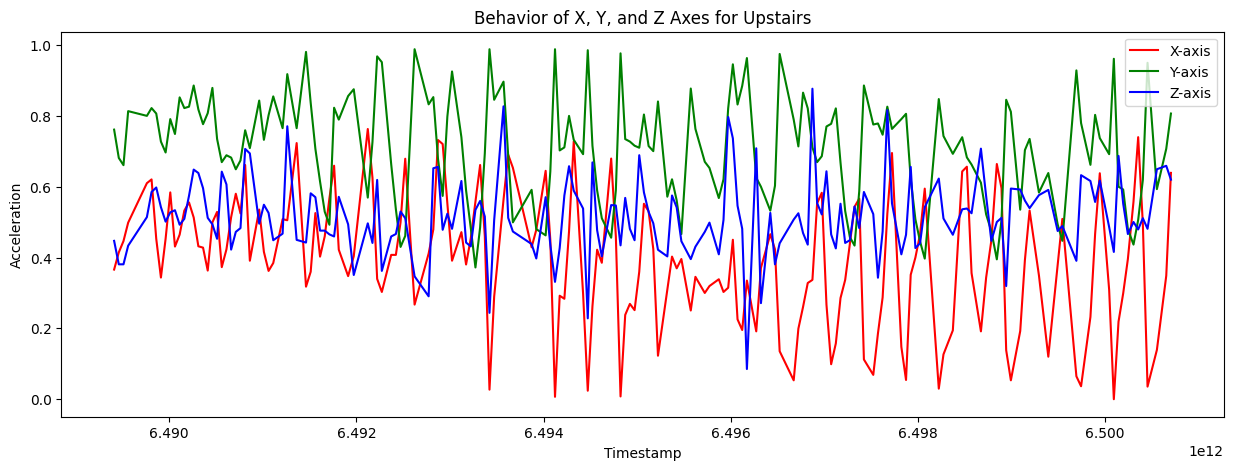

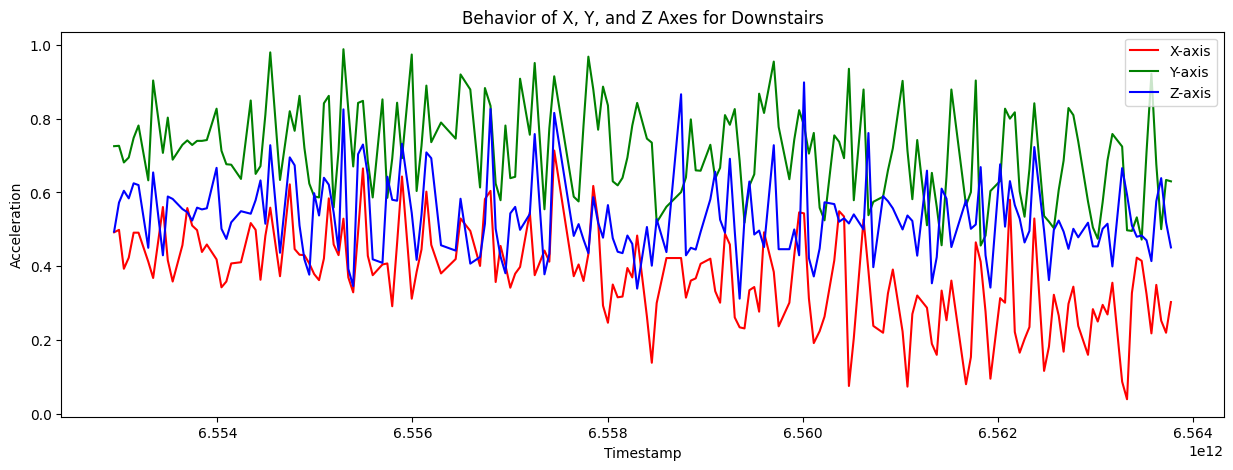

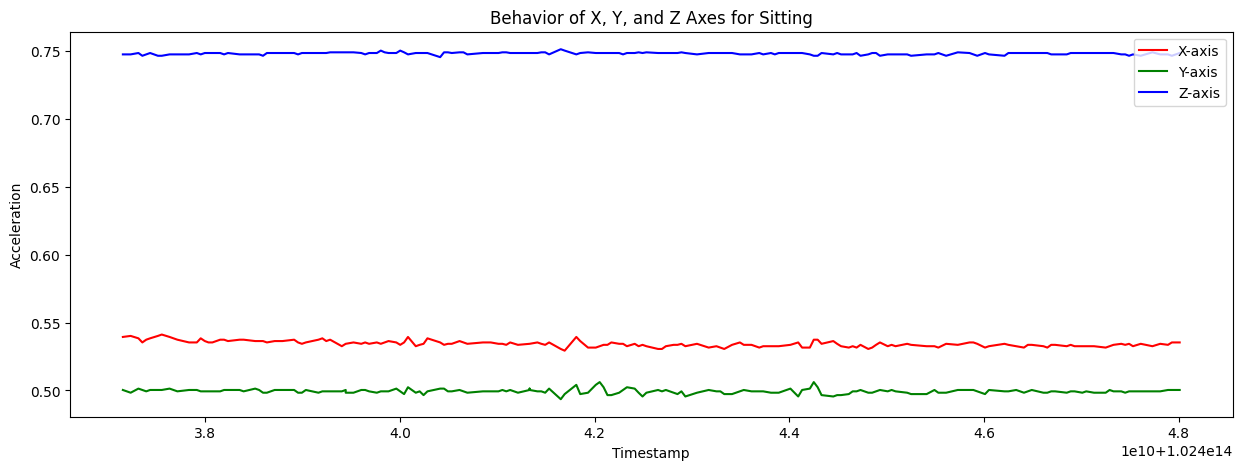

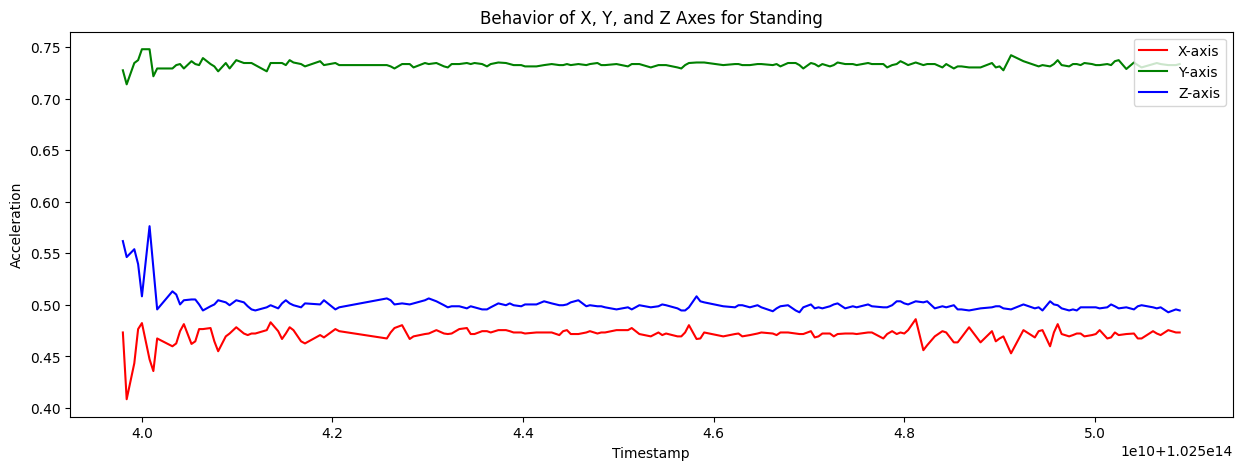

In [ ]:


# X,Y and Z behaviour plot for various activities 
for activity in har_df['activity'].unique():
    activity_data = har_df[har_df['activity'] == activity][:180]  # I have limited to the first 180 data points as it may become complex.
    
    plt.figure(figsize=(15, 5))
    plt.title(f'Behavior of X, Y, and Z Axes for {activity}')
    
    plt.plot(activity_data['timestamp'], activity_data['x-axis'], label='X-axis', color='r')
    
    plt.plot(activity_data['timestamp'], activity_data['y-axis'], label='Y-axis', color='g')
    
    plt.plot(activity_data['timestamp'], activity_data['z-axis'], label='Z-axis', color='b')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Acceleration')
    plt.legend(loc='upper right')
    
    plt.show()


In [61]:
# Define the sequence/window size (50 records for 2.5 seconds) for training-validation data
window_size = 50

# Generate sequences and labels for training
sequences = []
labels = []

for user_id, user_data in har_df.groupby('user'):
    user_sequences = []
    user_labels = []

    # Perform windowing here
    for i in range(0, len(user_data) - window_size + 1):
        window = user_data.iloc[i:i + window_size]
        sequence = window[['x-axis', 'y-axis', 'z-axis']].values
        label = window['activityEncode'].values[-1]
        user_sequences.append(sequence)
        user_labels.append(label)

    sequences.extend(user_sequences)
    labels.extend(user_labels)

sequences = np.array(sequences)
labels = np.array(labels)


In [63]:
# Initialize StratifiedKFold, "MODEL"
n_splits = 5  
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scores = []
test_losses = []
test_accuracies = []
train_accuracies = []

# Initialize variables for confusion matrix
n_activities = har_df['activityEncode'].nunique()
total_confusion = np.zeros((n_activities, n_activities))

# Initialize lists to store accuracy and loss during training
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

In [65]:
# Train-validation
for train_index, test_index in skf.split(sequences, labels):
    X_train, X_test = sequences[train_index], sequences[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [68]:
# Model Architecture with Dropout Regularization
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(window_size, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))  # Add dropout and L2 regularization
model.add(Dense(n_activities, activation='softmax'))

#Early Stopping
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)


Epoch 1/100
2692/2692 - 40s - loss: 0.7757 - accuracy: 0.7313 - val_loss: 0.6713 - val_accuracy: 0.7459 - 40s/epoch - 15ms/step
Epoch 2/100
2692/2692 - 37s - loss: 0.6271 - accuracy: 0.7764 - val_loss: 0.5707 - val_accuracy: 0.7950 - 37s/epoch - 14ms/step
Epoch 3/100
2692/2692 - 37s - loss: 0.5919 - accuracy: 0.7866 - val_loss: 0.5536 - val_accuracy: 0.7970 - 37s/epoch - 14ms/step
Epoch 4/100
2692/2692 - 38s - loss: 0.5684 - accuracy: 0.7939 - val_loss: 0.5573 - val_accuracy: 0.7983 - 38s/epoch - 14ms/step
Epoch 5/100
2692/2692 - 38s - loss: 0.5495 - accuracy: 0.7995 - val_loss: 0.5047 - val_accuracy: 0.8177 - 38s/epoch - 14ms/step
Epoch 6/100
2692/2692 - 44s - loss: 0.5350 - accuracy: 0.8042 - val_loss: 0.5221 - val_accuracy: 0.8084 - 44s/epoch - 16ms/step
Epoch 7/100
2692/2692 - 41s - loss: 0.5242 - accuracy: 0.8080 - val_loss: 0.4824 - val_accuracy: 0.8221 - 41s/epoch - 15ms/step
Epoch 8/100
2692/2692 - 41s - loss: 0.5150 - accuracy: 0.8121 - val_loss: 0.4665 - val_accuracy: 0.8276 

In [69]:
# Append training and validation accuracy and loss to lists
train_accuracies.extend(history.history['accuracy'])
val_accuracies.extend(history.history['val_accuracy'])
train_losses.extend(history.history['loss'])
val_losses.extend(history.history['val_loss'])

In [70]:
# Evaluation
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

1346/1346 [==============================] - 4s 3ms/step


Mean F1 Score: 0.9016 (±0.0000)
Mean Training Loss: 0.2744 (±0.0000)
Mean Validation Accuracy: 0.9047 (±0.0000)
Mean Training Accuracy: 0.8523 (±0.0320)


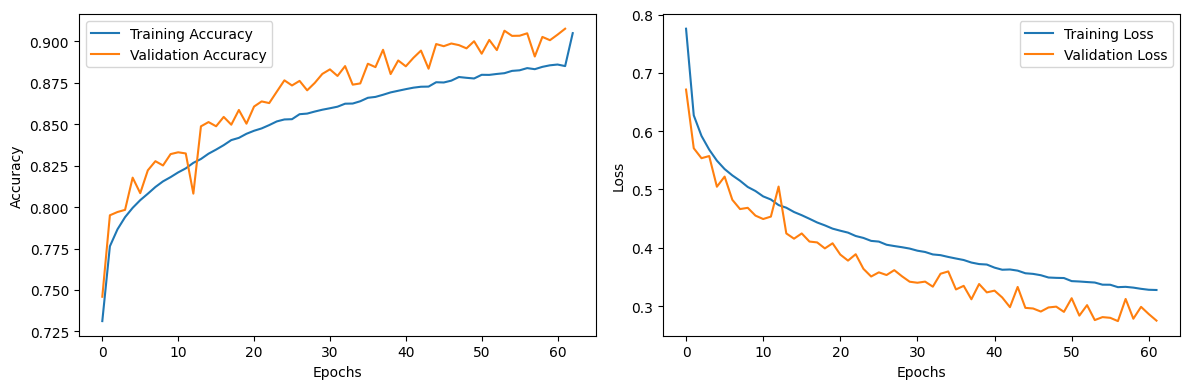

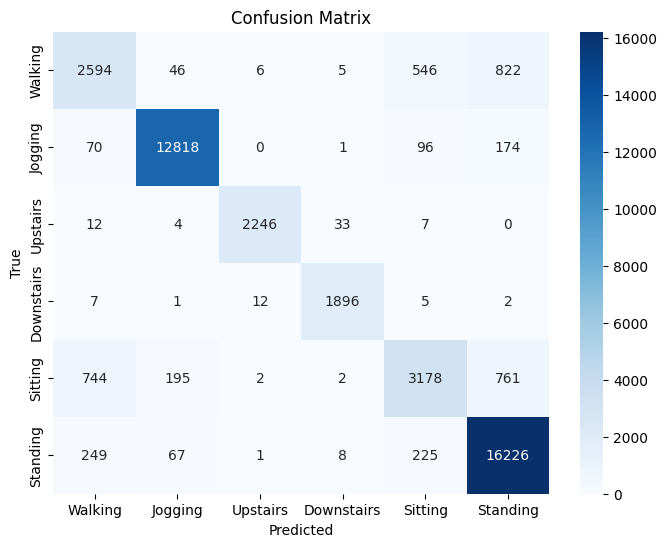

In [71]:

confusion = confusion_matrix(y_test, y_pred_labels)
total_confusion += confusion

f1 = f1_score(y_test, y_pred_labels, average='weighted')

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)

f1_scores.append(f1)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

mean_test_loss = np.mean(test_losses)
std_test_loss = np.std(test_losses)

mean_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

mean_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)

print(f"Mean F1 Score: {mean_f1:.4f} (±{std_f1:.4f})")
print(f"Mean Training Loss: {mean_test_loss:.4f} (±{std_test_loss:.4f})")
print(f"Mean Validation Accuracy: {mean_test_accuracy:.4f} (±{std_test_accuracy:.4f})")
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f} (±{std_train_accuracy:.4f})")

# Plot accuracy (training vs validation)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss (training vs validation)
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

# Display the square confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(total_confusion.astype(int), annot=True, fmt='d', cmap='Blues',
            xticklabels=har_df['activity'].unique(),
            yticklabels=har_df['activity'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

6729/6729 [==============================] - 17s 3ms/step
Test Loss: 0.2719
Test Accuracy: 0.9048
Test F1 Score: 0.9014


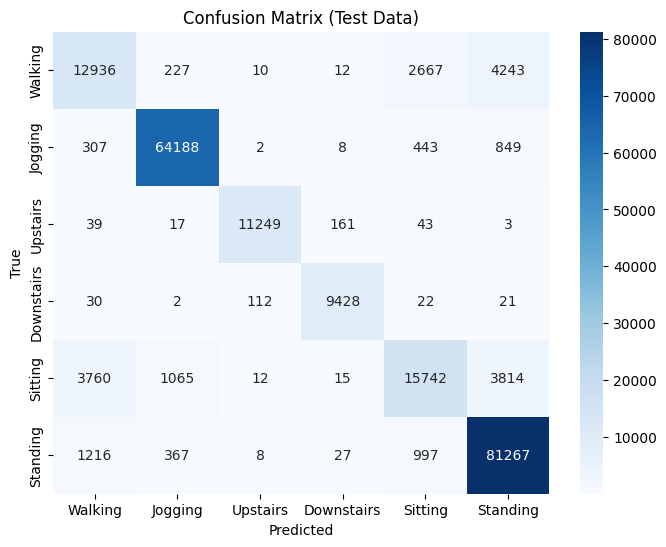

In [83]:
# Define the sequence/window size (50 records for 2.5 seconds) for test data
window_size = 50

test_sequences = []
test_labels = []

for user_id, user_data in test_df.groupby('user'):
    user_test_sequences = []
    user_test_labels = []

    # Perform windowing here for test data
    for i in range(0, len(user_data) - window_size + 1):
        window = user_data.iloc[i:i + window_size]
        sequence = window[['x-axis', 'y-axis', 'z-axis']].values
        label = window['activityEncode'].values[-1]
        user_test_sequences.append(sequence)
        user_test_labels.append(label)

    test_sequences.extend(user_test_sequences)
    test_labels.extend(user_test_labels)

test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

test_loss, test_accuracy = model.evaluate(test_sequences, test_labels, verbose=0)

y_test_pred = model.predict(test_sequences)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

f1_test = f1_score(test_labels, y_test_pred_labels, average='weighted')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")

test_confusion = confusion_matrix(test_labels, y_test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion.astype(int), annot=True, fmt='d', cmap='Blues',
            xticklabels=har_df['activity'].unique(),
            yticklabels=har_df['activity'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()
